In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/knotek/jupyterlab/source/semantic-segmentation


/home/knotek/miniconda3/envs/semseg/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import logging
logging.basicConfig(level=logging.INFO)

import semseg.io as io

In [3]:
from pathlib import Path
root = Path('/home/knotek/jupyterlab/data/delisa_2024/labeled/')
with open(root/'test.txt') as f:
    test_names= {f.strip() for f in f.readlines()}

# Load Images

In [5]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

img_all_paths = list(root.rglob('250*/**/img.png'))

img_paths = []
test_img_paths = []
for p in img_all_paths:
    sample_name = p.parent.name
    if sample_name in test_names:
        test_img_paths.append(p)
    else:
        img_paths.append(p)


model_path = Path('/home/knotek/jupyterlab/training/delisa_2024_250/model.pth')
label_paths = [ p.parent/'label.png' for p in img_paths]

imgs = list(map(io.read_image_normalized,tqdm(img_paths)))
labels = list(map(io.read_image_normalized,tqdm(label_paths)))

test_label_paths = [ p.parent/'label.png' for p in test_img_paths]

test_imgs = list(map(io.read_image_normalized,tqdm(test_img_paths)))
test_labels = list(map(io.read_image_normalized,tqdm(test_label_paths)))

/home/knotek/miniconda3/envs/semseg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 12/12 [00:02<00:00,  5.62it/s]


In [7]:
# imgs = sum([imgs]*10,[]) # HACK fix batch problems
# labels = sum([labels]*10,[])

# Prepare DataLoaders

In [8]:
import semseg.dataset as ds
patch_size = 128
x_channels = 1
train_augumentation_fn = ds.setup_augumentation(
    patch_size = patch_size,
    elastic=True,
    brightness_contrast=True,
    blur_sharp_power=1,
    flip_horizontal=False,
    flip_vertical=False,
    noise_value=0.01,
    rotate_deg=10
    )
val_augumentation_fn = ds.setup_augumentation(patch_size = patch_size)

train_dl,val_dl = ds.prepare_dataloaders(
    imgs,
    labels,
    train_augumentation_fn,
    val_augumentation_fn,
    batch_size= 32,
    val_size = 0.25,
    x_channels=x_channels
)

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.12 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


# Model

In [9]:
from segmentation_models_pytorch import Unet

model = Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=x_channels,
    classes=3,
    activation="sigmoid"
)

# Loss

In [10]:
from semseg.training import FocalLoss

loss = FocalLoss(alpha = .8,gamma=2)

# Training



In [13]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from tqdm.contrib.logging import logging_redirect_tqdm
from semseg.training import train

checkpoint_path = model_path.parent/f"checkpoint-{model_path.name}"
with logging_redirect_tqdm():
    train_loss,val_loss = train(
        model,
        train_dl,
        val_dl,
        loss,
        checkpoint_path=checkpoint_path,
        patience=20,
        scheduler_patience= 10,
        device = device
    )

model_path.parent.mkdir(exist_ok=True,parents=True)
torch.save(model, model_path)

# Test

In [ ]:
import semseg.prediction as prd

test_preds = prd.segment_many(model,test_imgs,device = device,x_channels=x_channels)

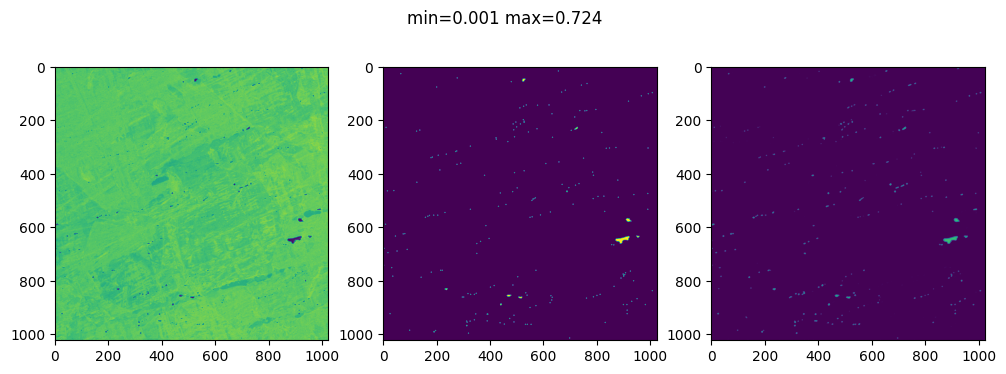

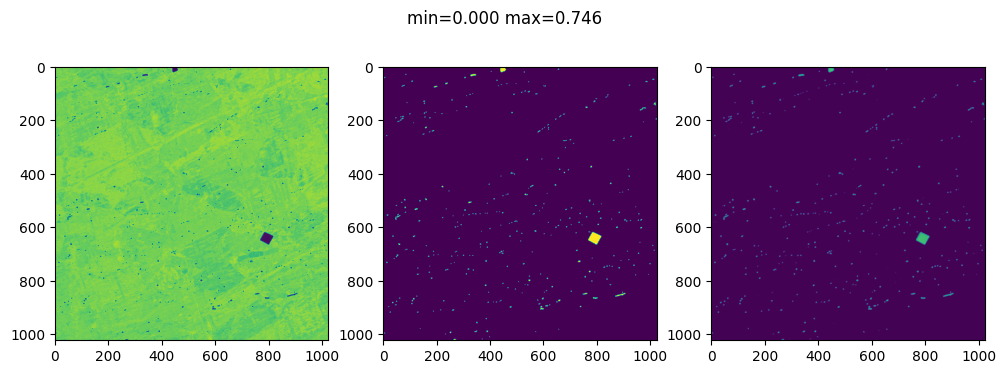

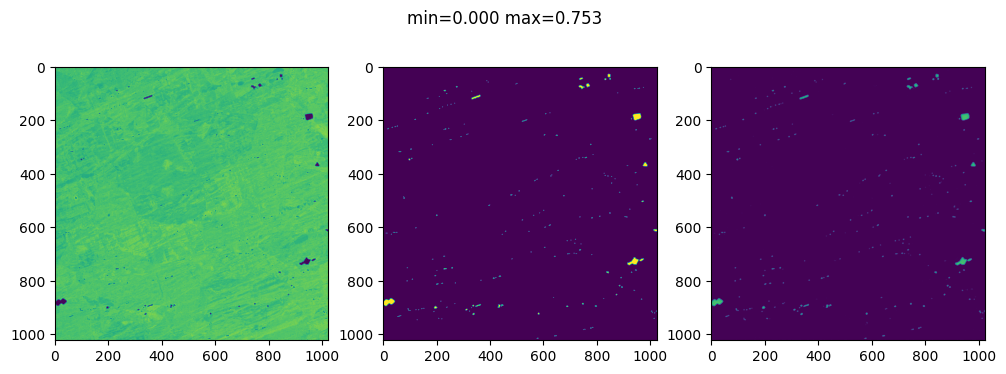

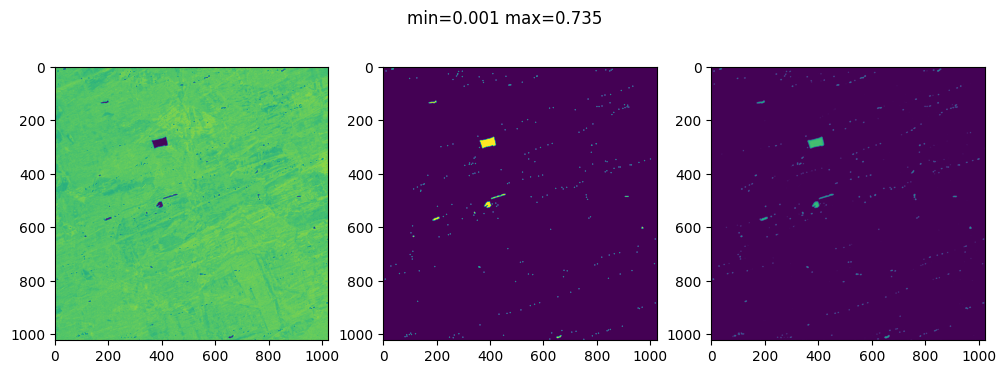

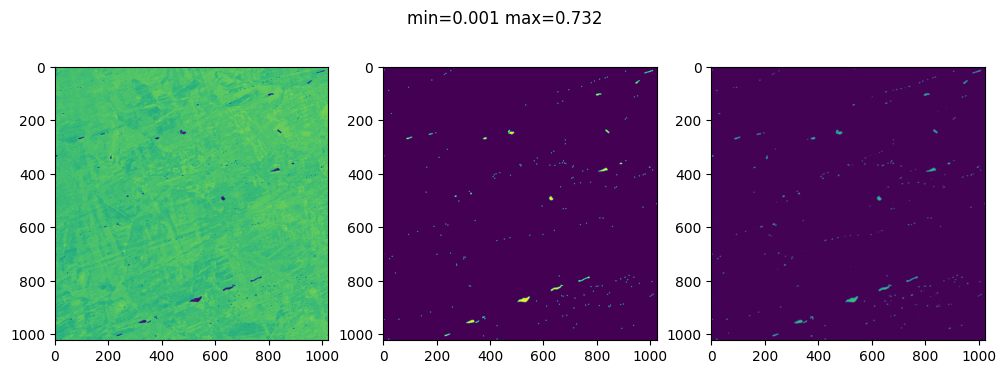

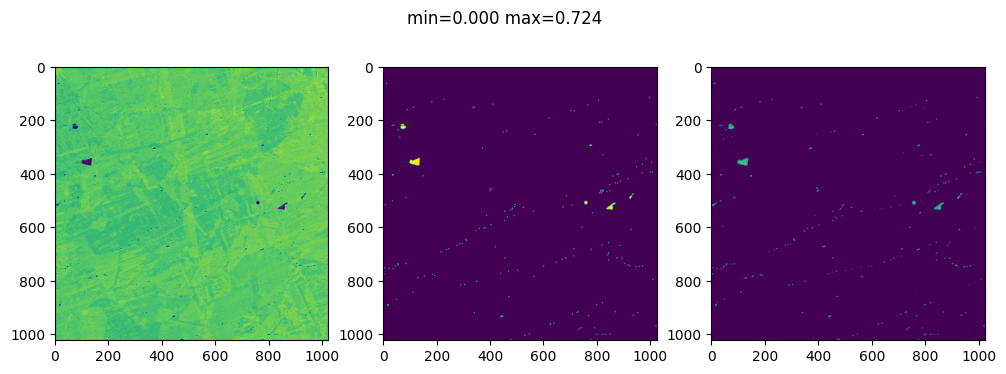

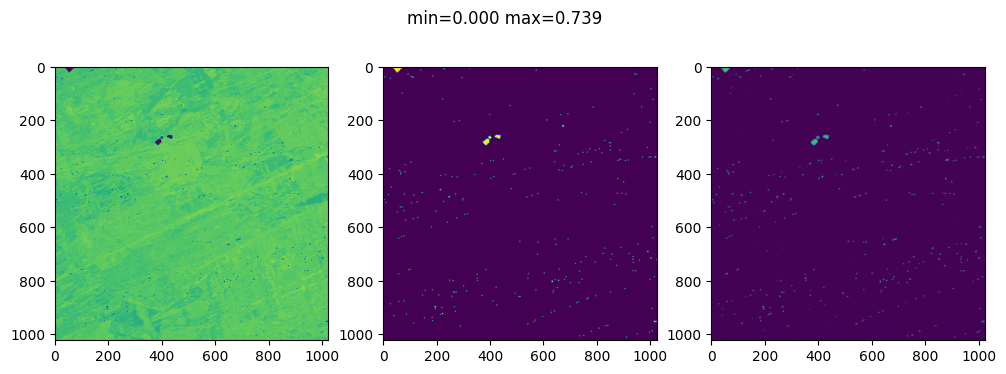

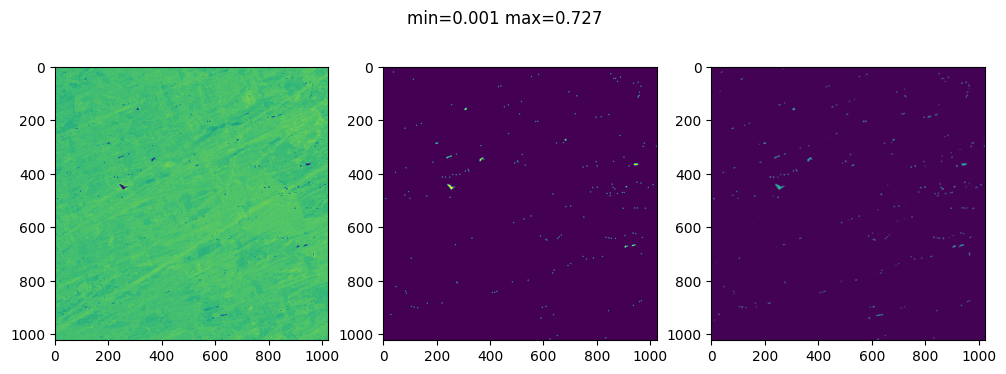

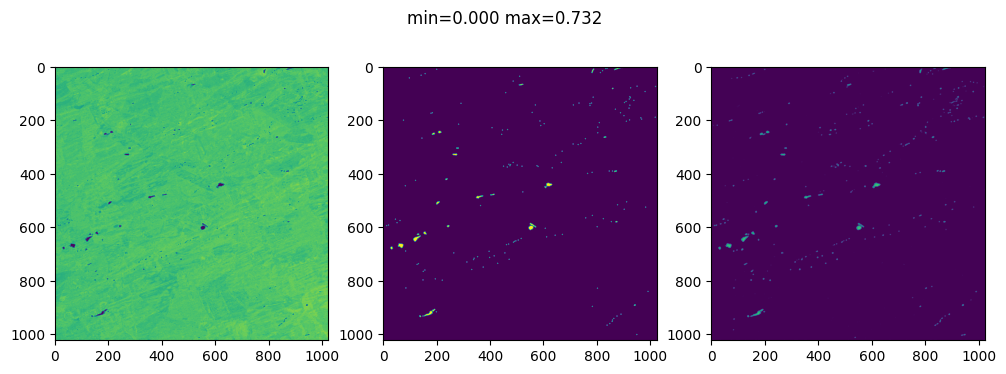

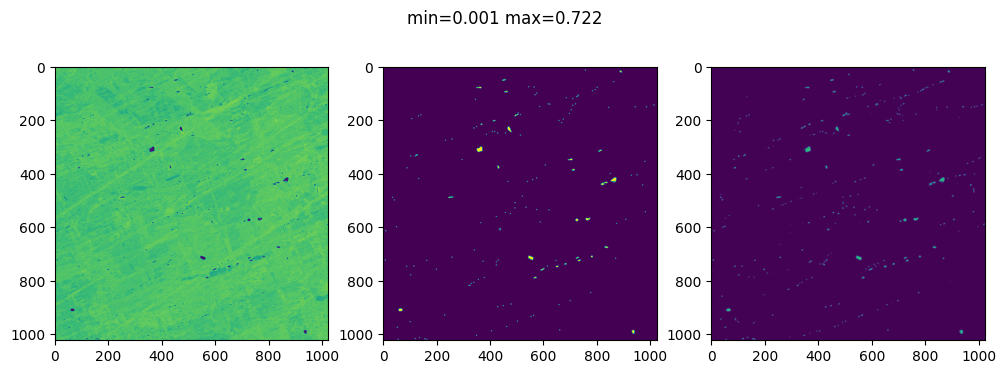

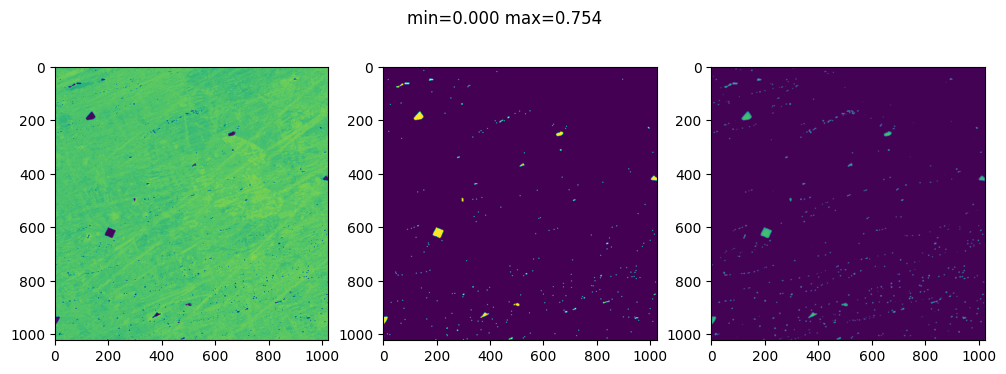

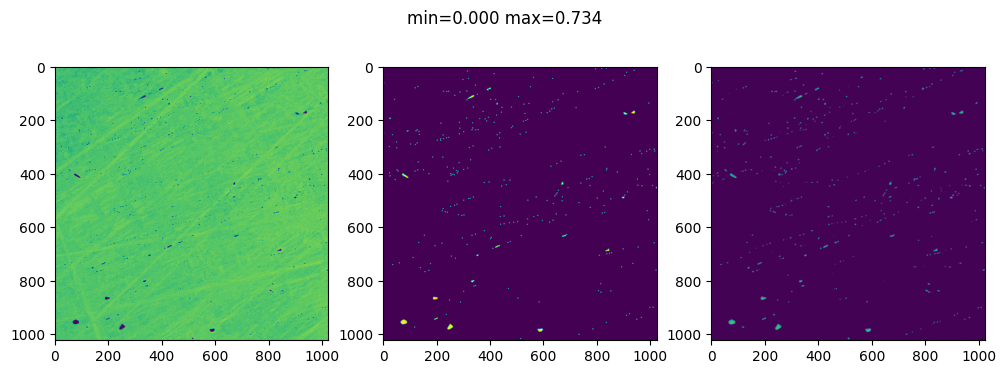

In [27]:
test_labels = [filter_small(lbl,area_limit=small_filter) for lbl in test_labels]
for img,label,pred in zip(test_imgs,test_labels,test_preds):
    fig,axs = plt.subplots(1,3,figsize=(12,4))
    axs[0].imshow(img,vmin=0,vmax=1)
    axs[1].imshow(label,vmin=0,vmax=1)
    axs[2].imshow(pred,vmin=0,vmax=1)
    title = f"min={np.min(pred):.3f} max={np.max(pred):.3f}"
    plt.suptitle(title)
    plt.show()

In [57]:
import numpy as np
import semseg.instance_matching as im

def measure_labeled(thr, labels,predictions):
    precisions = []
    recalls = []
    for label,prediction in tqdm(list(zip(labels,predictions))):
        pred_thr = np.uint8(prediction>=thr)
        label_thr = np.uint8(label)

        pred_thr = filter_small(pred_thr,small_filter)
        precision,recall,f1 = im.measure_precision_recall_f1(pred_thr,label_thr,component_limit=1000)
        precisions.append(precision)
        recalls.append(recall)
        
    mean_precision = np.mean(precisions)
    mean_recall = np.mean(recalls)
    mean_f1 = 2* (mean_precision*mean_recall)/(mean_precision + mean_recall)
    return mean_precision,mean_recall, mean_f1

threshold=  .4
mean_precision,mean_recall, mean_f1 = measure_labeled(threshold,test_labels,test_preds)
print(f"{mean_precision=:.2f} {mean_recall=:.2f} {mean_f1=:.2}")

100%|██████████| 12/12 [02:00<00:00, 10.01s/it]

mean_precision=0.95 mean_recall=0.74 mean_f1=0.83
